In [1]:
import numpy as np
from numpy import array as arr
from scipy.stats import chi2
from tabulate import tabulate

In [2]:
import sys
import socket
if socket.gethostname() == 'Birks-iMac.fritz.box':
    sys.path.append('/Users/Birk/Documents/Programmieren/Python/Eigener Code')
else:
    sys.path.append('/Home/ab227/linux/Eigener Code')
from pap import *
from pap import _rundung, _istbool

# pap.chi_quadrat_odr Entwicklung

In [ ]:
def chi_quadrat_odr(fitfunktion, messpunkte, messfehler, parameter = arr([])):
    '''
    Printet den χ^2_reduziert-Wert und die Fitwahrscheinlichkeit für Messwerte mit sowohl 
    y- als auch x-Fehler.
    
    
    Parameter
    ---------
    fitfunktion : function  (nur |R -> |R)
    
    messpunkte : np.ndarray (2D, mit number-like Elementen)
        Muss die Form haben np.array([[Liste von x-Werten], [Liste von y-Werten]])
    
    messfehler : np.ndarray ((2D, mit number-like Elementen > 0)
        Muss die Form haben np.array([[Liste von x-Fehlern], [Liste von y-Fehlern]])
        Wenn ein Fehlerwert nicht > 0 ist, stoppt die Funktion und printet eine Fehlermeldung
    
    parameter : np.ndarray  (1D, mit number-like Elementen)), optional
        Liste der parameter der Fitfunktion.
        
    
    Beispiel
    --------
    >>> messpunkte = np.array([[0.9, 2.3, 4.5], [-2.0, -4.3, -8.6]])
    >>> messfehler = np.array([[0.1, 0.05, 0.08], [0.1, 0.4, 0.3]])
    >>> pap.chi_quadrat_odr(pap.prop_func, messpunkte, messfehler, np.array([-2]))
    χ^2_reduziert         = 1.36
    Fitwahrscheinlichkeit = 25.7%
    
    
    Funktionsprinzip
    ----------------
    Im normalen χ^2-Test (pap.chi_quadrat_test()) wird nur der (fehlernormierte) y-Abstand von Messwert 
    und Fitfunktion für den χ^2-Wert berechnet. Hier wird stattdessen der Abstand zu dem dem Messpunkt 
    nächstgelegen Punkt der Funktion berechnet, normiert auf sowohl x- als auch y-Fehler des 
    Messpunktes. Um dies mit hinreichender Genauigkeit zu ermöglichen, werden so viele Funktionspunkte 
    berechnet, dass 10 von ihnen auf die Länge des kleinsten x-Fehlers passen. 
    '''
    
    
    
    # Anzahl x-Werte bestimmen
    if messfehler[messfehler <= 0].size != 0:
        print('messfehler darf keine Fehler enthalten, die 0 oder negativ sind!')
        return
    
    x_wert_min = messpunkte[0][0] - 10 * messfehler[0][0]   # x-Wert Unter- und
    x_wert_max = messpunkte[0][-1] + 10 * messfehler[0][-1]   # Obergrenze
    x_fehler_min = np.min(messfehler[0])   # Kleinster x_Fehler
    anzahl_x_werte = np.int((x_wert_max - x_wert_min) / x_fehler_min * 10)
    
    anzahl_max = np.int(1e7)   # Obergrenze von 10 Mio. Punkten um max. Rechenzeit zu begrenzen
    if anzahl_x_werte > anzahl_max:
        anzahl_x_werte = anzahl_max
        
    x_werte = np.linspace(x_wert_min, x_wert_max, anzahl_x_werte)
    fitwerte = fitfunktion(x_werte, *parameter)
    
    
    # Abstandsberechnung normiert auf die Messfehler
    abstände_alle = np.linalg.norm(arr([(messpunkte[0][:, np.newaxis] - x_werte) 
                                        / messfehler[0][:, np.newaxis], 
                                        (messpunkte[1][:, np.newaxis] - fitwerte) 
                                        / messfehler[1][:, np.newaxis]]), axis = 0)
    abstände_min = np.min(abstände_alle, axis = 1)
    
    
    # χ^2- und Fitwahrscheinlichkeits-Berechnung
    anzahl_parameter = len(parameter)
    anzahl_messwerte = np.shape(messpunkte)[1]
    
    chi_quadrat = np.sum(abstände_min**2)
    freiheitsgrade = anzahl_messwerte - anzahl_parameter
    chi_quadrat_reduziert = chi_quadrat / freiheitsgrade 
    fit_wahrscheinlichkeit = (1 - chi2.cdf(chi_quadrat, freiheitsgrade)) * 100

    print(f"χ^2_reduziert         = {chi_quadrat_reduziert:.2f}") 
    print(f"Fitwahrscheinlichkeit = {fit_wahrscheinlichkeit:.1f}%")
    
    
    
    #% Nur zu Entwicklungszwecken, nicht ins pap.py mitnehmen!
    return x_werte

**Probleme & Verbesserungsvorschläge:**  
Die Suche nach dem nächsten Punkt der Funktion zu jedem Messwert versucht effizient zu sein, indem nur so viele Funktions-Punkte berechnet werden, dass auf der Länge des kleinsten x-Fehlers 20 Funktionspunkte liegen. So soll auch bei kleinen Fehlern eine gute Auflösung der Funktion garantiert sein, ohne dass mit unnötig vielen Punkten gerechnet wird. 
* Problematisch vom Rechenaufwand her ist, dass für jeden Messpunkt zur Mindestabstandsbestimmung alle Funktions-Punkte abgeklappert werden anstatt nur die in der Nähe.
* Problematisch für die Genauigkeit/Zuverlässigkeit dieser Berechnung ist, dass nur der kleinste x-Fehler für die Anzahl der Funktionspunkte entscheidend ist. So kann eine Situation entstehen mit einer Funktion mit steilen Abschnitten und mit Messpunkten, die große x- aber kleine y-Fehler haben, in welcher die berechneten Mindestabstände viel zu groß sind, da die y-Auflösung zu schlecht ist.

## Tests

In [4]:
import matplotlib.pyplot as plt

In [5]:
def one_over_x(x):
    return 1 / x

### Test 0 - Docstring-Beispiel

In [6]:
messpunkte = np.array([[0.9, 2.3, 4.5], [-2.0, -4.3, -8.6]])
messfehler = np.array([[0.1, 0.05, 0.08], [0.1, 0.4, 0.3]])


x_werte = chi_quadrat_odr(prop_func, messpunkte, messfehler, np.array([-2]))
fitwerte = prop_func(x_werte, np.array([-2]))

χ^2_reduziert         = 1.36
Fitwahrscheinlichkeit = 25.7%


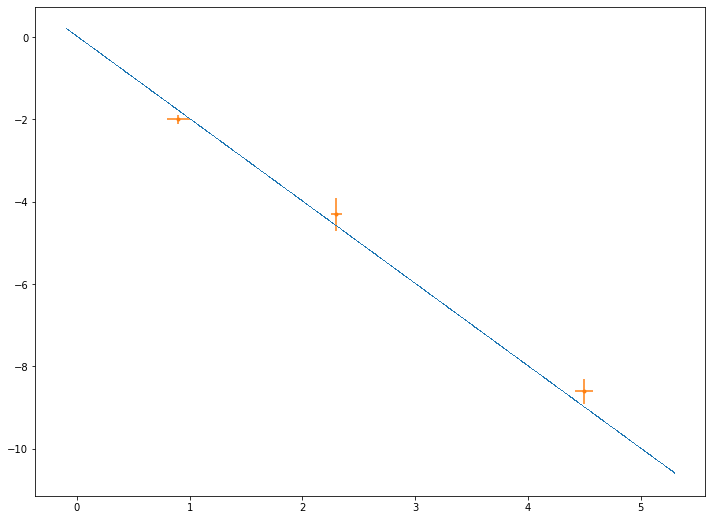

In [7]:
plt.figure(figsize = (12, 9))
plt.plot(x_werte, fitwerte, ',')
plt.errorbar(messpunkte[0], messpunkte[1], messfehler[1], messfehler[0], fmt = '.');

### Test 1 - Eine normale Funktion mit recht nahen Messwerten

In [8]:
messpunkte = arr([[-8, -5.5, -2.1, 1, 1.4, 3.2, 4.5], [40, 20.8, 3.1, 0.5, 1.5, 3, 6]])
messfehler = arr([[0.9, 0.5, 0.2, 0.5, 0.3, 0.09, 0.03], [5, 7.3, 4.2, 2.3, 2.3, 4.1, 4.4]])
parameter = arr([0.5, 0, -2])

x_werte = chi_quadrat_odr(quad_func, messpunkte, messfehler, parameter)
fitwerte = quad_func(x_werte, *parameter)

χ^2_reduziert         = 1.19
Fitwahrscheinlichkeit = 31.3%


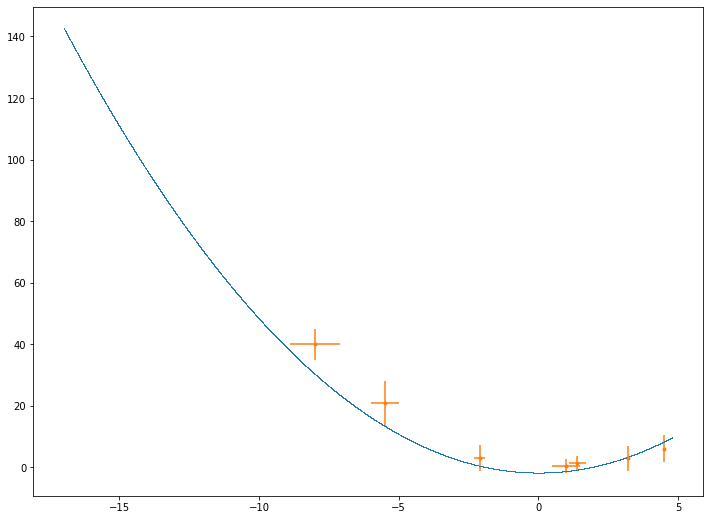

In [9]:
plt.figure(figsize = (12, 9))
plt.plot(x_werte, fitwerte, ',')
plt.errorbar(messpunkte[0], messpunkte[1], messfehler[1], messfehler[0], fmt = '.');

In [10]:
# Demonstration, dass der normale χ^2-Test hier ungeeignet ist.
chi_quadrat_test(one_over_x(messpunkte[0]), messpunkte[1], messfehler[1], 0)

χ^2_reduziert         = 10.81
Fitwahrscheinlichkeit = 0.0%


### Test 2 - Eine Funktion mit Polstellen

In [11]:
messpunkte = arr([[-8.48, -3.5, -2.58, -0, 0.01, 0.2, 9.9], 
                  [-0.01, -0.2, -0.5, -0, 10, 5, 0.05]])
messfehler = arr([[0.3, 0.2, 0.038, 0.3, 0.05, 0.084, 0.34], 
                  [0.05, 0.09, 0.2, 1.2, 1, 0.04, 0.03]])

x_werte = chi_quadrat_odr(one_over_x, messpunkte, messfehler)
fitwerte = one_over_x(x_werte)

χ^2_reduziert         = 2.51
Fitwahrscheinlichkeit = 1.4%


In [12]:
# Demonstration, dass der normale χ^2-Test hier ungeeignet ist.
chi_quadrat_test(one_over_x(messpunkte[0]), messpunkte[1], messfehler[1], 0)

χ^2_reduziert         = inf
Fitwahrscheinlichkeit = 0.0%


<ipython-input-5-d84e5ffd2af7>:2: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / x


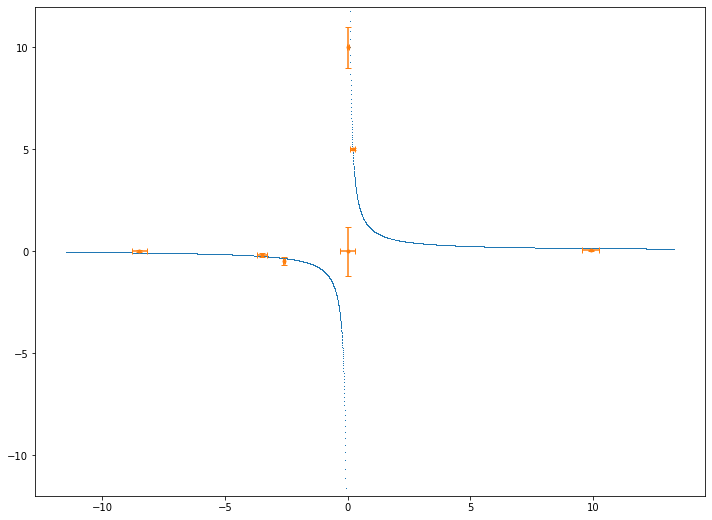

In [13]:
plt.figure(figsize = (12, 9))
plt.plot(x_werte, fitwerte, ',')
plt.errorbar(messpunkte[0], messpunkte[1], messfehler[1], messfehler[0], fmt = '.', capsize = 3)
plt.ylim(-12, 12);

### Test 3 - negative- und 0-Fehler

In [14]:
# Ein 0-Fehler
messpunkte = arr([[-8.48, -3.5, -2.58, -0, 0.01, 0.2, 9.9], 
                  [-0.01, -0.2, -0.5, -0, 10, 5, 0.05]])
messfehler = arr([[0.3, 0.2, 0.038, 0.3, 0.05, 0.084, 0.34], 
                  [0.05, 0.09, 0.2, 0, 1, 0.04, 0.03]])

x_werte = chi_quadrat_odr(one_over_x, messpunkte, messfehler)
# fitwerte = one_over_x(x_werte)

messfehler darf keine Fehler enthalten, die 0 oder negativ sind!


In [15]:
# Ein negativer Fehler
messpunkte = arr([[-8.48, -3.5, -2.58, -0, 0.01, 0.2, 9.9], 
                  [-0.01, -0.2, -0.5, -0, 10, 5, 0.05]])
messfehler = arr([[0.3, -0.2, 0.038, 0.3, 0.05, 0.084, 0.34], 
                  [0.05, 0.09, 0.2, 0, 1, 0.04, 0.03]])

x_werte = chi_quadrat_odr(one_over_x, messpunkte, messfehler)
# fitwerte = one_over_x(x_werte)

messfehler darf keine Fehler enthalten, die 0 oder negativ sind!
